In [1]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/workspaces/LLM-agent-with-Gemini/fleet-anagram-244304-7dafcc771b2f.json"

_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")
# _set_if_undefined("GEMINI_API_KEY")
# _set_if_undefined("GOOGLE_API_KEY")

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

In [2]:
from typing import Annotated, List, Tuple, Union

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

In [3]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI


def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [4]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [5]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser

members = ["Researcher", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(model="gpt-4-1106-preview")

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

In [6]:
import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


research_agent = create_agent(llm, [tavily_tool], "You are a web researcher.")
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_agent(
    llm,
    [python_repl_tool],
    "You may generate safe python code to analyze data and generate charts using matplotlib.",
)
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_chain)

In [7]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("supervisor")

graph = workflow.compile()

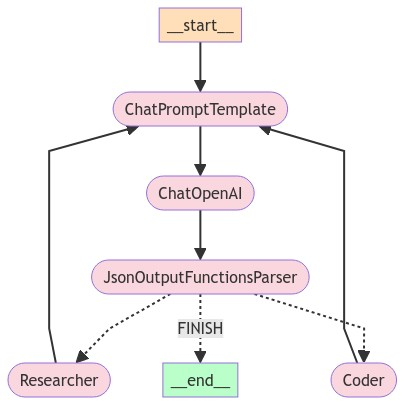

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [9]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Coder'}}
----


Python REPL can execute arbitrary code. Use with caution.


{'Coder': {'messages': [HumanMessage(content="The code `print('Hello, World!')` was executed, and it printed `Hello, World!` to the terminal.", name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [10]:
for s in graph.stream(
    {"messages": [HumanMessage(content="Write a brief summary of Google Gemini")]},
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='Google Gemini is a significant milestone in the development of AI introduced by Google. It represents a new era for the company in terms of AI innovations and responsible advancements. Gemini 1.0 is a multimodal AI model trained to recognize and understand text, images, audio, and more simultaneously, which allows it to process nuanced information and answer questions related to complex topics.\n\nGoogle Gemini is designed with state-of-the-art capabilities in nearly every domain and is part of a long-term commitment by Google to build collaboratively while setting safety and security benchmarks through organizations like MLCommons, the Frontier Model Forum, and its AI Safety Fund, as well as Google\'s own Secure AI Framework (SAIF).\n\nGemini comes in different sizes, including "Ultra," which is the most capable and largest model for highly complex tasks. Google has also integrated Gemini Pr